# Import libraries

In [1]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_log_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Configuration

In [2]:
COL_NAMES = [
    'Sex',
    'Length',
    'Diameter',
    'Height',
    'Whole weight',
    'Whole weight.1',
    'Whole weight.2',
    'Shell weight',
    'Rings']

NUMERICAL_COLS = ['Length',
    'Diameter',
    'Height',
    'Whole weight',
    'Whole weight.1',
    'Whole weight.2',
    'Shell weight']

CATEGORICAL_COL = ["Sex"]
SEED = 42

fold = KFold(n_splits=10, shuffle=True, random_state=SEED)

# Functions

In [3]:
def test_function():
    pass

# Import data

In [4]:
# Train data from Kaggle
org_train = pd.read_csv('data/train.csv')

# Orginal data from UCI
org_data = pd.read_csv('data/abalone.data', header=None, names=COL_NAMES)

In [5]:
# Enrich dataset
org_train.drop('id', axis=1, inplace=True)
df_master = pd.concat([org_train, org_data])

# Leave the original data as is
df = df_master.copy()
df.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


# EDA

In [6]:
print(f'Before concat: {org_train.shape}, {org_data.shape}\n')
print(f'After concat: {df_master.shape}, {df.shape}')

Before concat: (90615, 9), (4177, 9)

After concat: (94792, 9), (94792, 9)


In [7]:
# View columns stats
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94792 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             94792 non-null  object 
 1   Length          94792 non-null  float64
 2   Diameter        94792 non-null  float64
 3   Height          94792 non-null  float64
 4   Whole weight    94792 non-null  float64
 5   Whole weight.1  94792 non-null  float64
 6   Whole weight.2  94792 non-null  float64
 7   Shell weight    94792 non-null  float64
 8   Rings           94792 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 7.2+ MB


## Null & Duplicates analysis

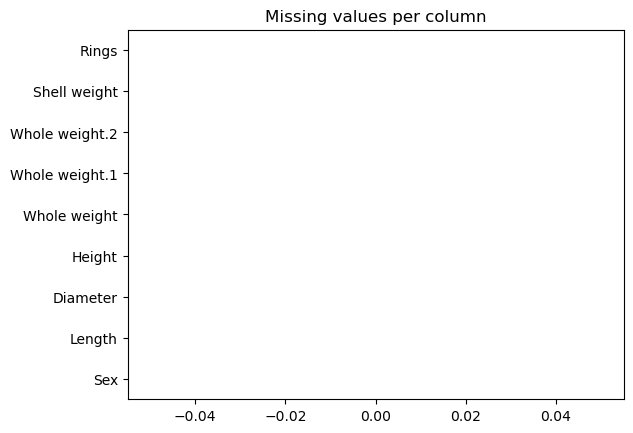

In [8]:
# Check for missing values with a horizontal bar plot
df.isnull().sum().plot(kind='barh')
plt.title('Missing values per column')
plt.show()

In [9]:
# Check for duplication
print(f'Number of duplicated records: {df.duplicated().sum()}')

Number of duplicated records: 0


## Categorical variables

In [10]:
# Select only categorical
categorical_columns = list(df.select_dtypes(include=['object']))
categorical_columns

['Sex']

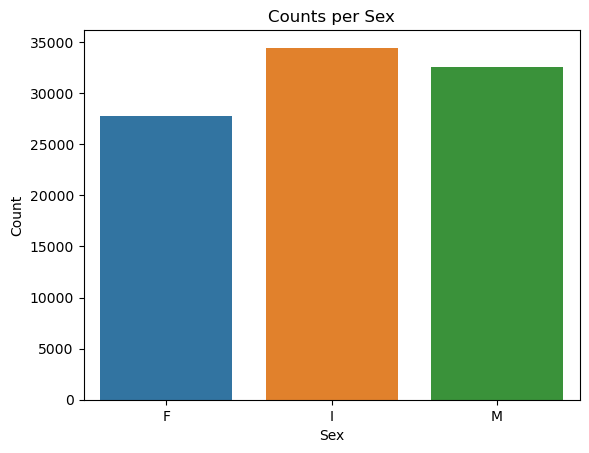

In [11]:
sns.countplot(data=df, x="Sex")
plt.title("Counts per Sex")
plt.ylabel("Count")
plt.show()

## Numerical variables

In [12]:
# Select only numerical
numerical_columns = list(df.select_dtypes(include=['float64', 'int64']))
numerical_columns

['Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight',
 'Rings']

In [13]:
# Check statistics
df[numerical_columns].describe().round(3)

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,94792.000,94792.000,94792.000,94792.000,94792.000,94792.000,94792.000,94792.000
mean,0.517,0.402,0.136,0.791,0.342,0.170,0.226,9.707
std,0.118,0.098,0.038,0.459,0.205,0.101,0.131,3.179
min,0.075,0.055,0.000,0.002,0.001,0.000,0.002,1.000
25%,0.445,0.345,0.110,0.420,0.178,0.086,0.120,8.000
50%,0.545,0.425,0.140,0.800,0.330,0.166,0.225,9.000
75%,0.600,0.470,0.160,1.072,0.464,0.233,0.305,11.000
max,0.815,0.650,1.130,2.826,1.488,0.760,1.005,29.000


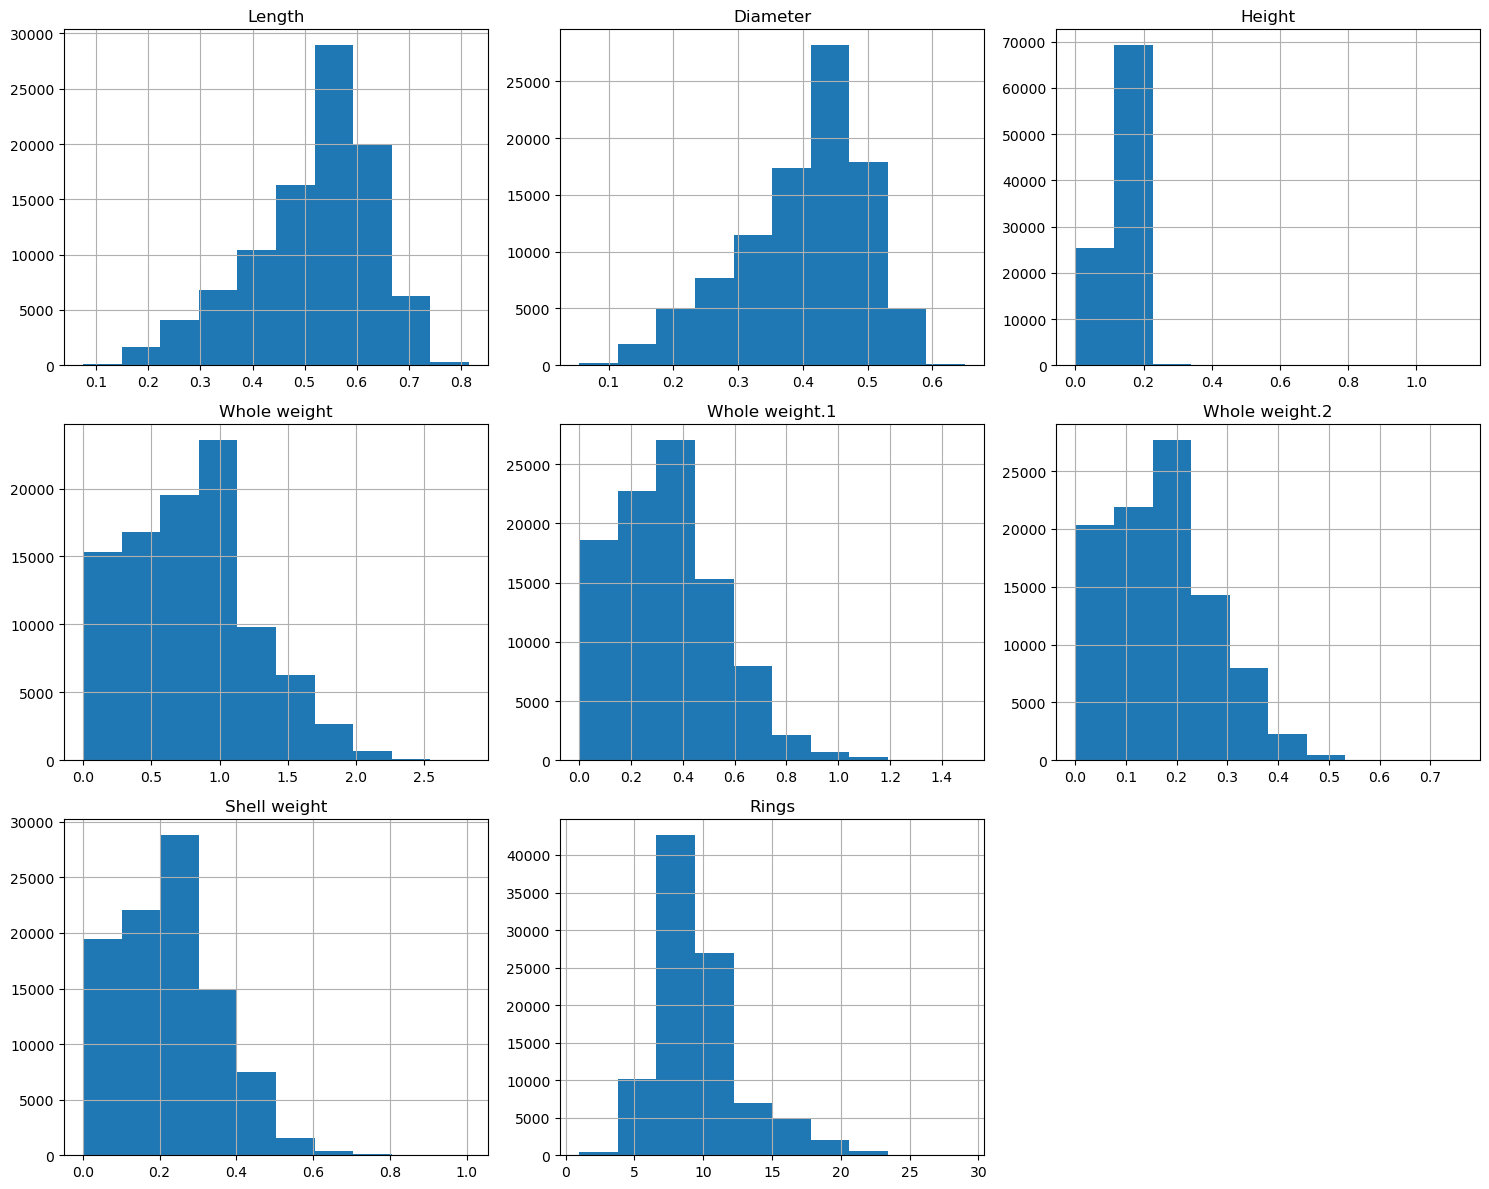

In [14]:
df.hist(figsize=(15, 12))
plt.tight_layout()
plt.show()

In [15]:
skew_coefficients = df[numerical_columns].skew()
skew_coefficients

Length           -0.727373
Diameter         -0.690925
Height            0.475841
Whole weight      0.436328
Whole weight.1    0.601075
Whole weight.2    0.485542
Shell weight      0.488303
Rings             1.200004
dtype: float64

## Correlation

In [16]:
# Create copy for correlation calculation
correlation_df = df.copy()

# Convert to use corr function
correlation_df.Sex = correlation_df.Sex.astype('category').cat.codes

# Create no target correlation matrix dataframe
no_target_df = correlation_df.drop('Rings', axis=1)

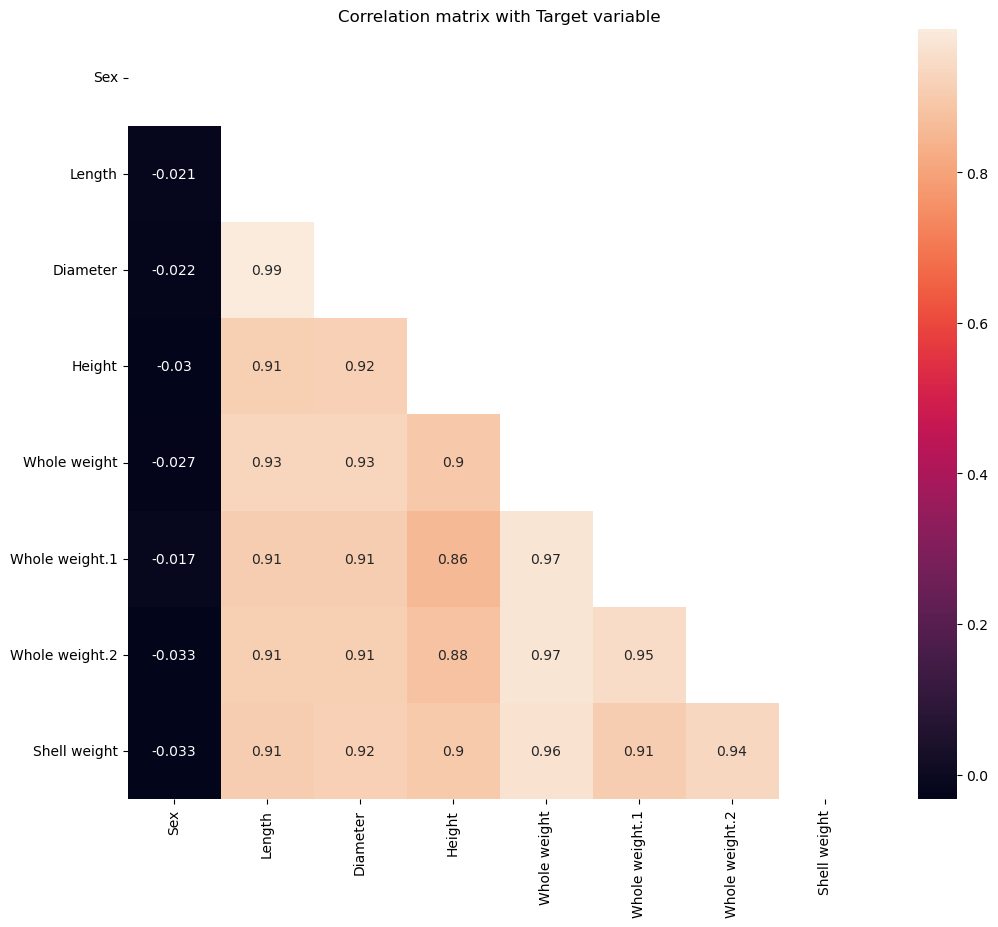

In [17]:
without_target_corr_matrix = no_target_df.corr()

# Create a mask for the upper triangle
mask_up_tri = np.triu(np.ones_like(without_target_corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(without_target_corr_matrix.round(3), annot=True, mask=mask_up_tri)
plt.title("Correlation matrix with Target variable")
plt.show()

In [18]:
# Calculate the correlation matrix with target
correlation_df.corr().abs()["Rings"].sort_values(ascending=False)

Rings             1.000000
Shell weight      0.691610
Height            0.660468
Diameter          0.634092
Length            0.620809
Whole weight      0.613666
Whole weight.2    0.584903
Whole weight.1    0.510597
Sex               0.026677
Name: Rings, dtype: float64

# Pre-processing

In [19]:
features = df.drop('Rings', axis=1)
target = df['Rings']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=SEED, stratify=target, shuffle=True
)

# Check the shape of the train and test data
print(f"Train data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

Train data shape: (75833, 8), (75833,)
Test data shape: (18959, 8), (18959,)


# Feature engineering

In [21]:
processor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), NUMERICAL_COLS),
        ('cat', OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_COL)
    ], remainder='passthrough'
)

In [22]:
X_train_processed = processor.fit_transform(X_train)
X_test_processed = processor.transform(X_test)

# Metric

The evaluation metric for this competition is the Root Mean Squared Logarithmic Error (RMSLE). 

The RMSLE is calculated as follows:

$$\text{RMSLE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\log(1+\hat{y}_i) - \log(1+y_i)\right)^2}$$

Where:
- $n \text{ is the total number of observations in the test set.}$
- $\hat{y}_i \text{ is the predicted value of the target for instance } i.$
- $y_i \text{ is the actual value of the target for instance } i.$
- $\log \text{ denotes the natural logarithm.}$

# Modeling

In [23]:
# Calculate gains
features_info_gain = mutual_info_classif(X_train_processed, y_train, random_state=SEED)

# Get the column names from the processor object
column_names = processor.get_feature_names_out(input_features=X_train.columns)

# Display information gain as a dataframe
info_gain_df = pd.DataFrame(features_info_gain, index=column_names, columns=['Information_Gain'])
info_gain_df.sort_values(by='Information_Gain', ascending=False, inplace=True)
info_gain_df

,Information_Gain
num__Shell weight,0.667512
num__Whole weight,0.569786
num__Height,0.543366
num__Diameter,0.535072
num__Whole weight.2,0.532627
num__Length,0.524995
num__Whole weight.1,0.499962
cat__Sex_I,0.231927
cat__Sex_F,0.074601
cat__Sex_M,0.060354


In [24]:
# Create regressors
xgb_reg = XGBRegressor()
catboost_reg = CatBoostRegressor()
adaboost_reg = AdaBoostRegressor()

## All features

In [25]:
# Calculate the execution time
start_time = time.time()

# Fit the regressors with cross validation
xgb_cv = cross_val_score(xgb_reg, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
catboost_cv = cross_val_score(catboost_reg, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
adaboost_cv = cross_val_score(adaboost_reg, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)

end_time = time.time()
print(f"\n\nExecution time with all features: {round(end_time - start_time, 2)} seconds")

Learning rate set to 0.079794
Learning rate set to 0.079794
Learning rate set to 0.079793
Learning rate set to 0.079794
Learning rate set to 0.079793
Learning rate set to 0.079793
Learning rate set to 0.079794
Learning rate set to 0.079794
0:	learn: 3.0544564	total: 68.9ms	remaining: 1m 8s
0:	learn: 3.0539380	total: 68.7ms	remaining: 1m 8s
0:	learn: 3.0604750	total: 68ms	remaining: 1m 7s
0:	learn: 3.0531215	total: 69.9ms	remaining: 1m 9s
0:	learn: 3.0533319	total: 70.7ms	remaining: 1m 10s
0:	learn: 3.0474221	total: 77.5ms	remaining: 1m 17s
0:	learn: 3.0565344	total: 81.2ms	remaining: 1m 21s
1:	learn: 2.9439346	total: 84.5ms	remaining: 42.2s
1:	learn: 2.9414453	total: 86.6ms	remaining: 43.2s
1:	learn: 2.9484139	total: 86.4ms	remaining: 43.1s
1:	learn: 2.9389626	total: 97.8ms	remaining: 48.8s
2:	learn: 2.8479336	total: 100ms	remaining: 33.3s
1:	learn: 2.9423852	total: 101ms	remaining: 50.5s
1:	learn: 2.9436789	total: 102ms	remaining: 50.7s
2:	learn: 2.8534594	total: 103ms	remaining: 34.1

In [26]:
cv_scores = [xgb_cv, catboost_cv, adaboost_cv]

# Convert negative RMSE values back to positive
cv_scores_positive = [-score for score in cv_scores]

# Calculate the mean of the positive RMSE scores
cv_mean = [round(np.mean(scores), 3) for scores in cv_scores_positive]

# Display as dataframe
all_features_rmse_scores = pd.DataFrame({"CV RMSE Mean": cv_mean}, index=[names for names in ["XGB", "CatBoost", "AdaBoost"]])
all_features_rmse_scores.sort_values(by="CV RMSE Mean", ascending=False)

,CV RMSE Mean
AdaBoost,3.491
XGB,1.867
CatBoost,1.845


## Feature set using Information gain Feature selection

In [27]:
# Drop the least important feature
info_gain_features = features.drop("Sex", axis=1)

X_train_ig, X_test_ig, y_train_ig, y_test_ig = train_test_split(info_gain_features, target, test_size=0.2, random_state=SEED, stratify=target, shuffle=True)

# Create a new processor
processor_ig = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), NUMERICAL_COLS)
    ], remainder='passthrough'
)

# Transform
X_train_ig_processed = processor_ig.fit_transform(X_train_ig)
X_test_ig_processed = processor_ig.transform(X_test_ig)

In [28]:
# Calculate the execution time
start_time = time.time()

# Fit the regressors with cross validation
xgb_cv = cross_val_score(xgb_reg, X_train_ig_processed, y_train_ig, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
catboost_cv = cross_val_score(catboost_reg, X_train_ig_processed, y_train_ig, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
adaboost_cv = cross_val_score(adaboost_reg, X_train_ig_processed, y_train_ig, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)

end_time = time.time()
print(f"\n\nExecution time with Information gain features: {round(end_time - start_time, 2)} seconds")

Learning rate set to 0.079793
Learning rate set to 0.079793
0:	learn: 3.0484777	total: 13.4ms	remaining: 13.4s
Learning rate set to 0.079793
Learning rate set to 0.079794
0:	learn: 3.0487802	total: 68.2ms	remaining: 1m 8s
1:	learn: 2.9357384	total: 83.6ms	remaining: 41.7s
1:	learn: 2.9361949	total: 91.2ms	remaining: 45.5s
2:	learn: 2.8342250	total: 104ms	remaining: 34.5s
0:	learn: 3.0557501	total: 40.9ms	remaining: 40.8s
0:	learn: 3.0535376	total: 44.9ms	remaining: 44.9s
Learning rate set to 0.079794
3:	learn: 2.7440075	total: 158ms	remaining: 39.4s
Learning rate set to 0.079794
Learning rate set to 0.079794
2:	learn: 2.8336419	total: 154ms	remaining: 51.2s
1:	learn: 2.9447268	total: 101ms	remaining: 50.6s
1:	learn: 2.9407605	total: 115ms	remaining: 57.4s
3:	learn: 2.7408619	total: 185ms	remaining: 46s
4:	learn: 2.6609205	total: 197ms	remaining: 39.2s
Learning rate set to 0.079794
0:	learn: 3.0467549	total: 30.6ms	remaining: 30.6s
0:	learn: 3.0518144	total: 39.9ms	remaining: 39.9s
5:	l

In [29]:
cv_scores = [xgb_cv, catboost_cv, adaboost_cv]

# Convert negative RMSE values back to positive
cv_scores_positive = [-score for score in cv_scores]

# Calculate the mean of the positive RMSE scores
cv_mean = [round(np.mean(scores), 3) for scores in cv_scores_positive]

# Display as dataframe
info_gain_features_rmse_scores = pd.DataFrame({"CV RMSE Mean": cv_mean}, index=[names for names in ["XGB", "CatBoost", "AdaBoost"]])
info_gain_features_rmse_scores.sort_values(by="CV RMSE Mean", ascending=False)

,CV RMSE Mean
AdaBoost,3.606
XGB,1.878
CatBoost,1.852


# Evaluation

## All features

In [30]:
# Fit to predict
catboost_reg.fit(X_train_processed, y_train)
y_pred_cat = catboost_reg.predict(X_test_processed)

# RMSE
print(f"\n\nCatBoost RMSLE: {mean_squared_log_error(y_test, y_pred_cat, squared=False)}")

Learning rate set to 0.081133
0:	learn: 3.0544635	total: 71.7ms	remaining: 1m 11s
1:	learn: 2.9441571	total: 87.7ms	remaining: 43.7s
2:	learn: 2.8402674	total: 95ms	remaining: 31.6s
3:	learn: 2.7460932	total: 106ms	remaining: 26.4s
4:	learn: 2.6630894	total: 110ms	remaining: 21.9s
5:	learn: 2.5897270	total: 116ms	remaining: 19.2s
6:	learn: 2.5248448	total: 121ms	remaining: 17.2s
7:	learn: 2.4723581	total: 127ms	remaining: 15.7s
8:	learn: 2.4234465	total: 133ms	remaining: 14.7s
9:	learn: 2.3754570	total: 144ms	remaining: 14.2s
10:	learn: 2.3326576	total: 149ms	remaining: 13.4s
11:	learn: 2.2944919	total: 153ms	remaining: 12.6s
12:	learn: 2.2612893	total: 158ms	remaining: 12s
13:	learn: 2.2299037	total: 162ms	remaining: 11.4s
14:	learn: 2.2026289	total: 165ms	remaining: 10.9s
15:	learn: 2.1786152	total: 169ms	remaining: 10.4s
16:	learn: 2.1571538	total: 174ms	remaining: 10s
17:	learn: 2.1374965	total: 177ms	remaining: 9.68s
18:	learn: 2.1205622	total: 182ms	remaining: 9.38s
19:	learn: 2.

## Information Gain

In [31]:
catboost_reg.fit(X_train_ig_processed, y_train_ig)
y_pred_cat_ig = catboost_reg.predict(X_test_ig_processed)

# RMSE
print(f"\n\nCatBoost RMSLE: {mean_squared_log_error(y_test_ig, y_pred_cat_ig, squared=False)}")

Learning rate set to 0.081133
0:	learn: 3.0508123	total: 4.96ms	remaining: 4.95s
1:	learn: 2.9363250	total: 8.62ms	remaining: 4.3s
2:	learn: 2.8335709	total: 12.3ms	remaining: 4.1s
3:	learn: 2.7429034	total: 15.6ms	remaining: 3.89s
4:	learn: 2.6601134	total: 19.2ms	remaining: 3.82s
5:	learn: 2.5882946	total: 22.7ms	remaining: 3.77s
6:	learn: 2.5251219	total: 26.5ms	remaining: 3.76s
7:	learn: 2.4687480	total: 30.9ms	remaining: 3.83s
8:	learn: 2.4168157	total: 34.6ms	remaining: 3.81s
9:	learn: 2.3692739	total: 38.9ms	remaining: 3.85s
10:	learn: 2.3261604	total: 44.2ms	remaining: 3.98s
11:	learn: 2.2905479	total: 48.4ms	remaining: 3.98s
12:	learn: 2.2599902	total: 52.5ms	remaining: 3.98s
13:	learn: 2.2360622	total: 57.4ms	remaining: 4.04s
14:	learn: 2.2086284	total: 62.2ms	remaining: 4.08s
15:	learn: 2.1855985	total: 66.5ms	remaining: 4.09s
16:	learn: 2.1656547	total: 73.6ms	remaining: 4.25s
17:	learn: 2.1457413	total: 81.5ms	remaining: 4.44s
18:	learn: 2.1277525	total: 87.9ms	remaining: 

# Prediction & Submission

In [32]:
test = pd.read_csv('data/test.csv')
sub = pd.read_csv('data/sample_submission.csv')

In [33]:
to_pred = test.drop('id', axis=1)

to_pred_processed = processor.transform(to_pred)

In [34]:
predictions = catboost_reg.predict(to_pred_processed)
sub["Rings"] = predictions
sub.to_csv("submission.csv", index=False)

# Reference